# First Prototype for generating a more sophisticated web app

import libs and load data

In [1]:
# local utilities
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities.BTTools import filter_for
from utilities.BTTools import groupSpeechesByDiscussionTitle

# other stuff needed
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import tqdm

import json

with open('../../data/speeches_20.jsonl', 'r', encoding='utf8') as fp:
    data = list(fp)
speeches_original = []
for line in data:
    speeches_original.append(json.loads(line))
    
speeches = speeches_original.copy()    

## 1. Topic Model at the level of TOPs


### 1.1 Create Corpus

#### restructure data per TOP

In [3]:
groupedby_discussion = groupSpeechesByDiscussionTitle(speeches)
len(groupedby_discussion)

208

#### build corpus for scikit learn methods

In [4]:
corpus = []
for top in groupedby_discussion.values():
    #print(grouped[top])
    aggregate= []
    for ele in top:
        aggregate.append(ele['text'])
    corpus.append(' '.join(aggregate))

len(corpus)    


208

#### optional: preprocessing with spacy

In [5]:

import spacy
nlp = spacy.load('de') #load spacy model


In [6]:

def corpus_by_POS(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.pos_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 


In [48]:
consider = ['NOUN']
        
corpus_nouns = corpus_by_POS(corpus,consider)        
len(corpus_nouns)

100%|██████████| 208/208 [02:43<00:00,  1.27it/s]


208

In [49]:
corpus = corpus_nouns
corpus[0]

'Kraft Wohle Volk Nutzen Schaden Grundgesetz Gesetz Bund Pflicht Gerechtigkeit'

### 1.2 Topic Model

#### vectorize data

In [50]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.8, min_df=0.01,lowercase = False)
tf_idf_matrix  = vectorizer_tfidf.fit_transform(corpus)
feature_names = vectorizer_tfidf.get_feature_names()
vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
tf_matrix = vectorizer_tf.fit_transform(corpus)

tf_idf_matrix

<208x7520 sparse matrix of type '<class 'numpy.float64'>'
	with 97685 stored elements in Compressed Sparse Row format>

#### compute topic model

In [51]:
# Use NMF to look for 15 topics
n_topics = 10
model = NMF(n_components=n_topics)
model.fit(tf_idf_matrix)
#model.fit(tf_matrix)

# Print the top 10 words
n_words = 10
n_words_features = 100

topic_list = []
topic_list_ext = []
topic_words = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 
    topic_list_ext.append(top_features)
    
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words_features:]][::-1]
    topic_words.append(top_n)

    print(f"Topic {topic_idx}: {top_features}")
    
topic2word = model.components_   
#topic_words

Topic 0: Energie Gas Ausbau Klimaschutz Strom Energieversorgung Antrag Energiewende EEG Erneuerbaren
Topic 1: Krieg Putin Russland Waffe Bundeskanzler Sanktion Friede Bundeswehr Präsident Waffenlieferungen
Topic 2: Impfpflicht Impfung Pandemie Pflege Variante Impfstoff Impfungen Impfen Virus Welle
Topic 3: Mandat Soldat Mission Soldatinnen Bundeswehr Einsatz Operation Südsudan Region Nation
Topic 4: Euro Milliarde Haushalt Investition Nachtragshaushalt Pandemie Wirtschaft Krise Sondervermögen Schuldenbremse
Topic 5: Landwirt Landwirtschaft Hunger Ernährung Lebensmittel Bauer Fläche Million Betrieb Agrarpolitik
Topic 6: Kind Kommune Ganztagsbetreuung Schule Bund Familie Bildung Jugendliche Registrierung Ministerin
Topic 7: Inflation Euro Entlastung Antrag Einkommen Preis Bürger Maßnahme Progression Rentner
Topic 8: Antrag Opfer Demokratie Anschlag Sicherheitsbehörden Rechtsextremismus Extremismus Rechtsstaat Straftat Kriminalität
Topic 9: Gesetz Gesetzentwurf Unternehmen Maßnahme Sankti

In [86]:
topic_list_ext

['Energie Gas Ausbau Klimaschutz Strom Energieversorgung Antrag Energiewende EEG Erneuerbaren',
 'Krieg Putin Russland Waffe Bundeskanzler Sanktion Friede Bundeswehr Präsident Waffenlieferungen',
 'Impfpflicht Impfung Pandemie Pflege Variante Impfstoff Impfungen Impfen Virus Welle',
 'Mandat Soldat Mission Soldatinnen Bundeswehr Einsatz Operation Südsudan Region Nation',
 'Euro Milliarde Haushalt Investition Nachtragshaushalt Pandemie Wirtschaft Krise Sondervermögen Schuldenbremse',
 'Landwirt Landwirtschaft Hunger Ernährung Lebensmittel Bauer Fläche Million Betrieb Agrarpolitik',
 'Kind Kommune Ganztagsbetreuung Schule Bund Familie Bildung Jugendliche Registrierung Ministerin',
 'Inflation Euro Entlastung Antrag Einkommen Preis Bürger Maßnahme Progression Rentner',
 'Antrag Opfer Demokratie Anschlag Sicherheitsbehörden Rechtsextremismus Extremismus Rechtsstaat Straftat Kriminalität',
 'Gesetz Gesetzentwurf Unternehmen Maßnahme Sanktion Regelung Antidiskriminierungsstelle Behinderung P

#### Word Clouds for Topic

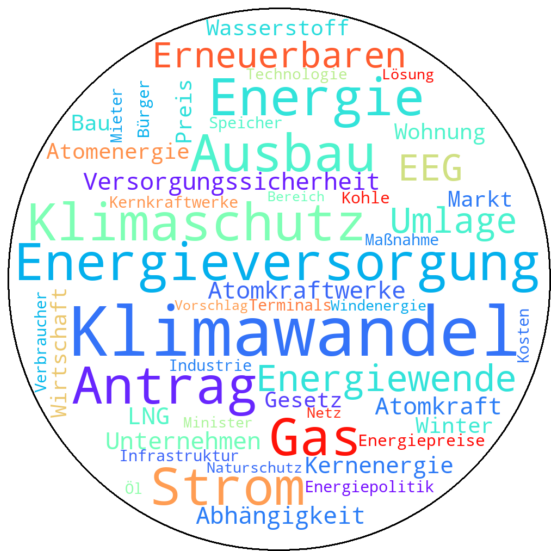

In [52]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud

mask = np.array(Image.open("circle.png"))

# parameters:

wordcloud = WordCloud(background_color='white', max_words=50, mask=mask, contour_color='#000000', contour_width=3, colormap='rainbow').generate(" ".join(topic_words[0]))

# create image as circle

fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# presentate:

plt.show()


# generate PNG for all topics
for tx,topic in enumerate(topic_words):
    wordcloud = WordCloud(background_color='white', max_words=50, mask=mask, contour_color='#000000', contour_width=3, colormap='rainbow').generate(" ".join(topic_words[tx]))

    wordcloud.to_file(f"wordclouds/wordcloud_{tx}.png")


#### document topic probabilities

In [53]:
print(tf_matrix.shape)
print(topic2word.shape)
doc2topic = (tf_matrix * topic2word.T)
print(doc2topic.shape)

(208, 7520)
(10, 7520)
(208, 10)


In [ ]:
topic2word.T[0]

## 1.3 Generate HTML page for single Topics

#### find max contributions for words and docs

In [54]:
feature_topic_num = []
feature_topic_name = []
for wx,word in enumerate(feature_names):
    if topic2word.T[wx].max() > 0:
        topic_num = topic2word.T[wx].argmax()
        topic_name = topic_list_ext[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    feature_topic_num.append(topic_num)
    feature_topic_name.append(topic_name)
#feature_topic_num

top_topic_num = []
top_topic_name = []
for tx,top in enumerate(groupedby_discussion):
    if doc2topic[tx].max() > 0:
        topic_num = doc2topic[tx].argmax()
        topic_name = topic_list_ext[topic_num]
    else:
        topic_num = n_topics
        topic_name = 'not defined'
    
    top_topic_num.append(topic_num)
    top_topic_name.append(topic_name)
    
#feature_topic_num

In [55]:
corpus[0]

'Kraft Wohle Volk Nutzen Schaden Grundgesetz Gesetz Bund Pflicht Gerechtigkeit'

#### This should go to a function

In [78]:

topic_index = 0

for topic_index, topic_name in enumerate(topic_list):

    # select TOPs for max. relevant topic
    #topic_selection = []
    #for tx,top in enumerate(groupedby_discussion):
    #    if top_topic_num[tx] == topic_index:
    #        topic_selection.append(groupedby_discussion[top])
    #        #print(top)

    # Alternative using the corpus
    topic_selection = []
    top_indices = []
    top_names = []
    for tx,top in enumerate(corpus):
        if top_topic_num[tx] == topic_index:
            topic_selection.append(top)
            top_indices.append(tx)
            top_names.append(list(groupedby_discussion.keys())[tx])
            #print(top)
    
    print(f'Topic {topic_index} has {len(topic_selection)} TOPs')
    
    # remove words that are max. relevant for topic        
    topic_features = []
    for wx,word in enumerate(feature_names):
        if feature_topic_num[wx] != topic_index:
            topic_features.append(word)

    #len(topic_features)

    # compute semantic similarity for selection
    if len(topic_selection) == 0:
        print(f'Topic {topic_index} cannot be constructed')
    else:
        vectorizer_topic = TfidfVectorizer(vocabulary=topic_features,lowercase = False)
        tf_idf_matrix_topic  = vectorizer_topic.fit_transform(topic_selection)
        pairwise_similarity_topic = tf_idf_matrix_topic * tf_idf_matrix_topic.T 
        similarity_topic = pairwise_similarity_topic.toarray()

        print(similarity_topic.shape)


        # build network
        # nodes:
        nodes = []
        count = 1
        for tx,top_ix in enumerate(top_indices):
            node_dict = {
                'id' : count,
                'top' : top_ix,
                'date' : groupedby_discussion[ top_names[tx] ][0]['date'],
                'nReden' : len( groupedby_discussion[ top_names[tx] ] )
            }
            nodes.append(node_dict)
            count += 1

        # graph construct
        graph = {
            'directed': False,
            'graph': 'semant_graph',
            'links': [],
            'nodes': nodes,
        }   

        # edges:
        min_weight = 0.15
        for ix,nodeI in enumerate(graph['nodes']):
            for jx,nodeJ in enumerate(graph['nodes']):
                if ix < jx:
                    source = nodeI['id']
                    target = nodeJ['id']
                    weight = similarity_topic[ix,jx]
                    if weight > min_weight:
                        link_dict = {
                            'source':source,
                            'target':target,
                            'weight':weight       
                        }
                        graph['links'].append(link_dict)


        nn = len(graph['nodes'])
        ne = len(graph['links'])
        print( f"This graph has {nn} nodes and {ne} links.")


        # write to HTML

        data = graph
        d3graph = {"nodes": [], "links": []}
        d3graph["nodes"] = data["nodes"]
        d3graph["links"] = data["links"]

        htmlcode = f"""<head>
            <style> body {{margin: 0;}} </style>
            <script src="https://unpkg.com/force-graph"></script>
            <meta charset="UTF-8">
        </head>
        <body>
        <div id="graph"></div>
        <script>
            var data = {d3graph};
            const elem = document.getElementById('graph');
            const Graph = ForceGraph()(elem)
                .graphData(data)
                .nodeLabel('top')
                .nodeRelSize(1)
                .nodeVal('nReden')
                //.linkVisibility('true')
                //.onNodeClick (node => {{window.open(`wordnet.html`, '_blank')}})
                //.onNodeHover(node => elem.style.cursor = node ? 'pointer' : null)
                .onNodeRightClick(node => {{
                    // Center/zoom on node
                    Graph.centerAt(node.x, node.y, 1000);
                    Graph.zoom(4, 2000);
                }});
        </script>
        </body>
        """

        with open (f"./TOPnets/TOPnet4topic{topic_index}.html", "w") as f:
            f.write(htmlcode)

Topic 0 has 97 TOPs
(97, 97)
This graph has 97 nodes and 826 links.
Topic 1 has 22 TOPs
(22, 22)
This graph has 22 nodes and 52 links.
Topic 2 has 15 TOPs
(15, 15)
This graph has 15 nodes and 78 links.
Topic 3 has 0 TOPs
Topic 3 cannot be constructed
Topic 4 has 3 TOPs
(3, 3)
This graph has 3 nodes and 0 links.
Topic 5 has 2 TOPs
(2, 2)
This graph has 2 nodes and 1 links.
Topic 6 has 37 TOPs
(37, 37)
This graph has 37 nodes and 173 links.
Topic 7 has 5 TOPs
(5, 5)
This graph has 5 nodes and 6 links.
Topic 8 has 2 TOPs
(2, 2)
This graph has 2 nodes and 1 links.
Topic 9 has 18 TOPs
(18, 18)
This graph has 18 nodes and 29 links.


In [64]:
#nodes

## 1.4 Generate Topic Network (I take now Julians Version)

In [99]:
from sklearn.metrics.pairwise import cosine_similarity

def get_topic2_topic(tm):
    normalized_matrix = normalize(tm.components_, axis=1, norm='l1')
    print(f'normalized_matrix: {normalized_matrix.shape}')

    topic_to_topic = cosine_similarity(normalized_matrix)
    print(f'topic2topic: {topic_to_topic.shape}')

    return topic_to_topic

def create_topic2topic_graph(t2t, extended_topic_list):
    nodes = []
    count = 1

    for i, topic in enumerate(t2t):
        nodes.append({
            'id': count,
            'topicname': extended_topic_list[i]
        })
        count += 1

    graph = {
        'directed': False,
        'graph': 'semant_graph',
        'links': [],
        'nodes': nodes
    }

    for i, node_i in enumerate(graph['nodes']):
        for j, node_j in enumerate(graph['nodes']):
            if i < j:
                source = node_i['id']
                target = node_j['id']
                weight = t2t[i, j]
                if weight > 0.15:
                    link = {
                        'source': source,
                        'target': target,
                        'weight': weight
                    }
                    graph['links'].append(link)

    return graph

def get_graph_template(graph, properties):
    node_label = properties['nodelabel']
    node_coloring = properties['nodecoloring']

    lv = '//' if properties['edgevisibility'] else ''
    parts = '//' if not properties['particles'] else ''
    dm = '//' if not properties['darkmode'] else ''

    d3graph = {
        'nodes': graph['nodes'],
        'links': graph['links']
    }

    htmlcode = f"""<head>
        <style>
            body {{margin: 0;}}
            h3 {{text-align: center;}}
            .center {{
              display: block;
              margin-left: auto;
              margin-right: auto;
            }}
        </style>
        <script src="https://unpkg.com/force-graph"></script>
        <meta charset="UTF-8">
    </head>
    <body>
    <img src="Logo.png" height="150" width="300" class="center">
    <h3>DebSearch ist eine statistische Website, welche die aktuelle Legislaturperiode</h3>
    <h3>in verschiedenen Kategorieren auswertet und visualisiert.</h3>
    <div id="graph"></div>
    <script>
        var data = {d3graph};
        const elem = document.getElementById('graph');
        const Graph = ForceGraph()(elem)
            .graphData(data)
            .nodeLabel('{node_label}')
            .nodeRelSize(3)
            .nodeVal('nReden')
            .nodeAutoColorBy('{node_coloring}')
            {dm}.backgroundColor('#000000')
            {dm}.linkColor(() => 'rgba(255,255,255,0.2)')
            {lv}.linkVisibility('false')
            {parts}.linkDirectionalParticles(2)
            {parts}.linkDirectionalParticleWidth(1.4)
            //.onNodeClick (node => {{window.open('./TOPnets/TOPnet4topic0.html', '_blank')}})
            .onNodeClick (node => {{window.open(`./TOPnets/TOPnet4topic${{node.id-1}}.html`, '_blank')}})
            //.onNodeHover(node => elem.style.cursor = node ? 'pointer' : null)
            .onNodeRightClick(node => {{
                // Center/zoom on node
                Graph.centerAt(node.x, node.y, 1000);
                Graph.zoom(4, 2000);
            }});
    </script>
    </body>
    """

    return { 'graph': htmlcode }

In [100]:
topic2topic = get_topic2_topic(model)

t2t_graph = create_topic2topic_graph(topic2topic, topic_list)

print(f"got a graph with {len(t2t_graph['nodes'])} nodes.")
print('the first node:')
print(t2t_graph['nodes'][0])


properties = {
    'nodecoloring':'topicname',
    'nodelabel': 'topicname',
    "darkmode": False,
    "edgevisibility": True,
    "particles": False
}

html_graph = get_graph_template(t2t_graph, properties)

with open(f'./topic_network.html', 'w') as f:
    f.write(html_graph['graph'])

normalized_matrix: (10, 7520)
topic2topic: (10, 10)
got a graph with 10 nodes.
the first node:
{'id': 1, 'topicname': 'topic_Energie_Gas_Ausbau'}


## Additional Stuff

### X.1 Temporal Evolution

In [ ]:
def groupSpeechesByDate(speeches):
    groupedSpeeches = {}
    speeches.sort(key = lambda x:x['date'])
    for speech in speeches:
        top = speech['date']
        if top in groupedSpeeches:
            groupedSpeeches[top].append(speech)
        else:
            groupedSpeeches[top] = [speech]
    
    return groupedSpeeches


groupedby_date = groupSpeechesByDate(speeches)
len(groupedby_date)


#groupedby_date['2022-04-27']

In [ ]:
groupedby_date.keys()

In [ ]:
corpus_by_date = []
for docs in groupedby_date.values():
    #print(grouped[top])
    aggregate= []
    for ele in docs:
        aggregate.append(ele['text'])
    corpus_by_date.append(' '.join(aggregate))

len(corpus_by_date) 
#corpus_by_date[0]

In [ ]:
consider = set([x for xs in topic_words for x in xs])
#consider

In [ ]:

#consider = feature_names

consider = set([x for xs in topic_words for x in xs])

def corpus_by_Features(corpus,consider):
    corpus_by = []  
    for row in tqdm.tqdm(corpus):
        doc = nlp(row)
        new_row = []
        for token in doc:
            if token.lemma_ in consider:
                new_row.append(token.lemma_)
        corpus_by.append(' '.join(new_row))
    return corpus_by 
     
corpus_by_date_features = corpus_by_Features(corpus_by_date,consider)        
len(corpus_by_date_features)

In [ ]:
#corpus_by_date_features[1]
feature_names.index('und')
#topic_words
len(consider)

In [ ]:
evo_vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
evo_tf_matrix = evo_vectorizer_tf.fit_transform(corpus_by_date_features)
print(evo_tf_matrix.shape)
print(topic2word.shape)

topic2word_norm = normalize(topic2word, norm='l1', axis=0, copy=True, return_norm=False)

time2topic = evo_tf_matrix.dot(topic2word_norm.T)
print(time2topic.shape)
print(time2topic.sum(axis=1))

In [ ]:
plt.figure(figsize=(10, 5))
#plt.plot(groupedby_date.keys(),time2topic,label = topic_list)
plt.stackplot(groupedby_date.keys(),time2topic.T)

plt.xticks(rotation=65, ha='right')
#plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.01, 1.01))
#locs, labels = xticks()
#xticks(locs,)
plt.show()